In [202]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.datasets import StochasticBlockModelDataset
from torch_geometric.utils import to_networkx
from torch_geometric.utils import to_dense_adj
from torch_geometric.transforms import RandomNodeSplit

In [203]:
num_nodes_per_class = 100
num_nodes = [num_nodes_per_class] * 3
edge_probs = [[0.1, 0.05, 0.02],
              [0.05, 0.1, 0.02],
              [0.02, 0.02, 0.1]]
dataset = StochasticBlockModelDataset('./data', num_nodes, edge_probs, num_channels=10)


In [204]:
colors = cm.tab10.colors
y_colors = np.array(colors)[dataset[0].y.numpy()]

In [205]:
dataset[0]

Data(x=[300, 10], edge_index=[2, 4692], y=[300])

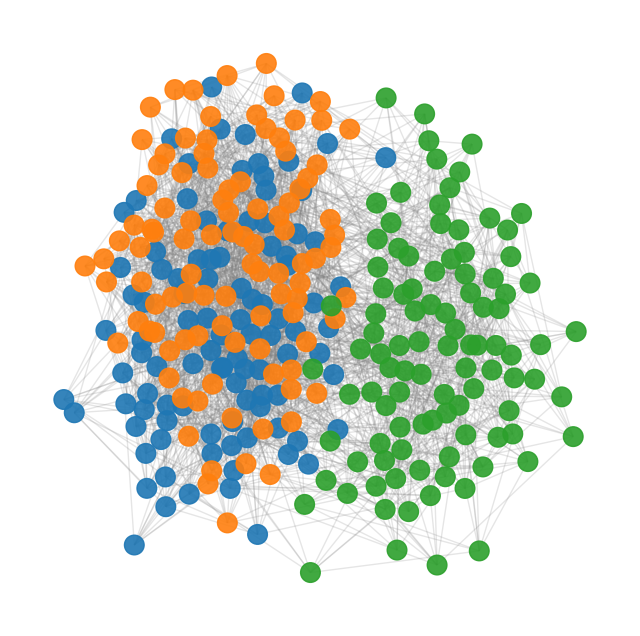

In [206]:
G = to_networkx(dataset[0], to_undirected=True)
node_pos=nx.spring_layout(G, seed=0)
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx_nodes(G,
                pos=node_pos,
                node_size=200,
                node_color=y_colors,
                alpha=0.9
                )
nx.draw_networkx_edges(G,
                pos=node_pos,
                edge_color="grey",
                alpha=0.2
                )
plt.show()

In [207]:
split = RandomNodeSplit(num_val=0.1, num_test=0.1)
data = split(dataset[0])
data

Data(x=[300, 10], edge_index=[2, 4692], y=[300], train_mask=[300], val_mask=[300], test_mask=[300])

In [208]:
class GraphConvolution(torch.nn.Module):
    def __init__(self,in_features, out_features, bias = True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
            
            
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'
     
    def forward(self,input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

In [209]:
class GCN(nn.Module):
    def __init__(self, nfeat,nhid,nclass,dropout):
        super(GCN,self).__init__()
        self.gc1= GraphConvolution(nfeat,nhid)
        self.gc2= GraphConvolution(nhid,nclass)
        self.dropout = dropout
    def forward(self,x,adj):
        x  = F.relu(self.gc1(x,adj))
        x = F.dropout(x,self.dropout,training=self.training)
        x = self.gc2(x,adj)
        return F.log_softmax(x,dim=1)

In [210]:
adj = to_dense_adj(data.edge_index)[0]
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj) #make the adj symetric
adj = adj + torch.eye(adj.shape[0])

d = np.zeros((adj.shape[0],adj.shape[0]))
np.fill_diagonal(d, adj.sum(1).numpy())
d = torch.from_numpy(d)


d_inv_sqrt = torch.pow(d, -0.5)
d_inv_sqrt = torch.nan_to_num(d_inv_sqrt, posinf=0.0)
d_inv_sqrt = d_inv_sqrt.to(dtype=torch.float32)
adj = (d_inv_sqrt @ adj) @ d_inv_sqrt

features = data.x
features = nn.functional.normalize(features)
labels = data.y
idx_train = data.train_mask
idx_val = data.val_mask
idx_test = data.test_mask

In [211]:
model = GCN(nfeat=features.shape[1],
            nhid=3,
            nclass=labels.max().item()+1,
            dropout=0.5)

In [212]:
optimizer = optim.Adam(model.parameters(), lr= 0.02, weight_decay=5e-4)

In [213]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [214]:
loss_train_list = []
loss_val_list = []

In [215]:
for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    output = model(features,adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    loss_train_list.append(loss_train.item())
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()
    
    model.eval()
    output = model(features,adj)
    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    loss_val_list.append(loss_val.item())
    acc_val = accuracy(output[idx_val], labels[idx_val])
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Train Acc: {acc_train.item()*100:.2f}% | Validation Acc: {acc_val.item()*100:.2f}%')
    
    

Epoch   0 | Train Acc: 32.50% | Validation Acc: 36.67%
Epoch  10 | Train Acc: 35.00% | Validation Acc: 30.00%
Epoch  20 | Train Acc: 51.25% | Validation Acc: 43.33%
Epoch  30 | Train Acc: 67.08% | Validation Acc: 83.33%
Epoch  40 | Train Acc: 73.33% | Validation Acc: 73.33%
Epoch  50 | Train Acc: 78.33% | Validation Acc: 76.67%
Epoch  60 | Train Acc: 74.58% | Validation Acc: 90.00%
Epoch  70 | Train Acc: 80.00% | Validation Acc: 93.33%
Epoch  80 | Train Acc: 79.17% | Validation Acc: 90.00%
Epoch  90 | Train Acc: 76.67% | Validation Acc: 90.00%
Epoch 100 | Train Acc: 83.33% | Validation Acc: 90.00%
Epoch 110 | Train Acc: 85.83% | Validation Acc: 83.33%
Epoch 120 | Train Acc: 80.83% | Validation Acc: 90.00%
Epoch 130 | Train Acc: 82.50% | Validation Acc: 83.33%
Epoch 140 | Train Acc: 80.83% | Validation Acc: 93.33%
Epoch 150 | Train Acc: 81.25% | Validation Acc: 90.00%
Epoch 160 | Train Acc: 80.83% | Validation Acc: 93.33%
Epoch 170 | Train Acc: 86.67% | Validation Acc: 93.33%
Epoch 180 

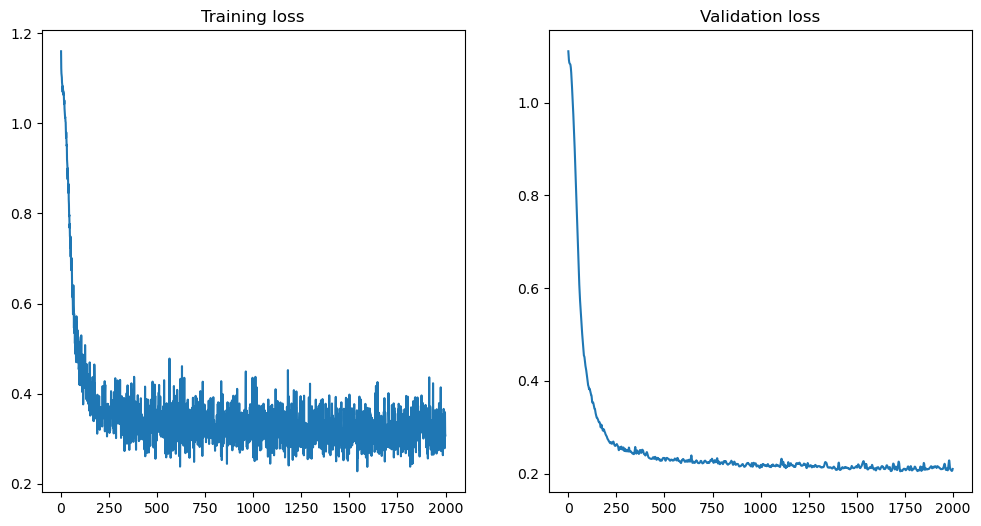

In [216]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(loss_train_list)
ax1.set_title('Training loss')
ax2.plot(loss_val_list)
ax2.set_title('Validation loss')
plt.show()

In [217]:
model.eval()
output = model(features, adj)
loss_test = F.nll_loss(output[idx_test], labels[idx_test])
idx_test_preds = output[idx_test].max(1)[1].type_as(labels)
acc_test = accuracy(output[idx_test], labels[idx_test])
print(f'Test Acc: {acc_test.item()*100:.2f}% | Test loss: {loss_test.item():.2f}')

Test Acc: 100.00% | Test loss: 0.14


In [218]:
torch.sum(labels[idx_test]!=idx_test_preds).item()


0

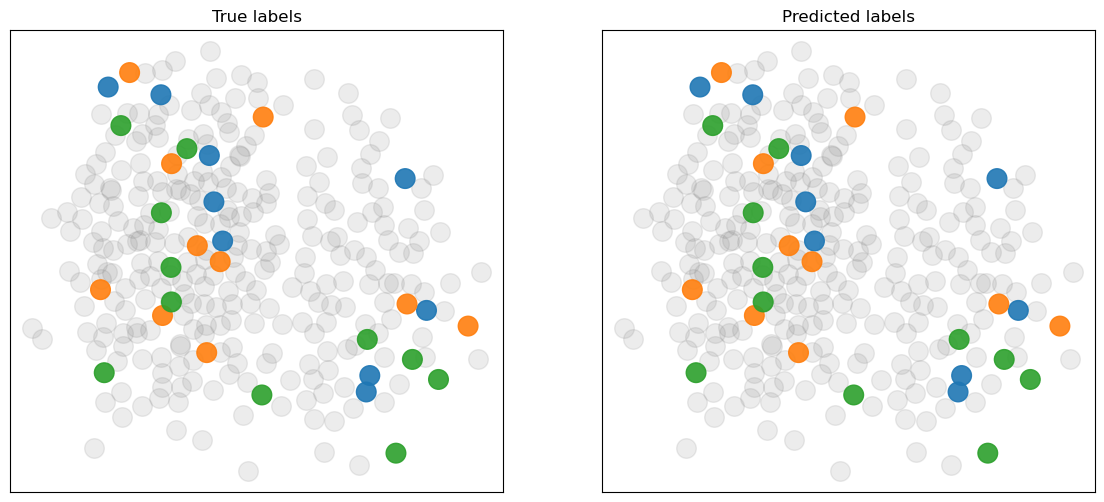

In [219]:
G1 = nx.from_numpy_array(adj.numpy())
node_pos=nx.spring_layout(G, seed=0)

idx_train_nodes = np.nonzero(idx_train.numpy())[0]
idx_val_nodes = np.nonzero(idx_val.numpy())[0]
idx_test_nodes = np.nonzero(idx_test.numpy())[0]

idx_train_graph = G.subgraph(idx_train_nodes.tolist())
idx_val_graph = G.subgraph(idx_val_nodes.tolist())

idx_test_graph = G.subgraph(idx_test_nodes.tolist())
idx_test_graph_colors_true = np.array(colors)[labels[idx_test]]
idx_test_graph_colors_preds = np.array(colors)[idx_test_preds]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.set_title('True labels')
nx.draw_networkx_nodes(idx_train_graph,
                pos=node_pos,
                node_size=200,
                node_color='grey',
                alpha=0.15,
                ax = ax1
                )
nx.draw_networkx_nodes(idx_val_graph,
                pos=node_pos,
                node_size=200,
                node_color='grey',
                alpha=0.15,
                ax = ax1
                )
nx.draw_networkx_nodes(idx_test_graph,
                pos=node_pos,
                node_size=200,
                node_color=idx_test_graph_colors_true,
                alpha=0.9,
                ax = ax1
                )

ax2.set_title('Predicted labels')
nx.draw_networkx_nodes(idx_train_graph,
                pos=node_pos,
                node_size=200,
                node_color='grey',
                alpha=0.15,
                ax = ax2
                )
nx.draw_networkx_nodes(idx_val_graph,
                pos=node_pos,
                node_size=200,
                node_color='grey',
                alpha=0.15,
                ax = ax2
                )
nx.draw_networkx_nodes(idx_test_graph,
                pos=node_pos,
                node_size=200,
                node_color=idx_test_graph_colors_preds,
                alpha=0.9,
                ax = ax2
                )

plt.show()

In [220]:
model

GCN(
  (gc1): GraphConvolution (10 -> 3)
  (gc2): GraphConvolution (3 -> 3)
)

In [221]:
embeddings = F.relu(model.gc1(features, adj)).detach().numpy()
embeddings.shape

(300, 3)

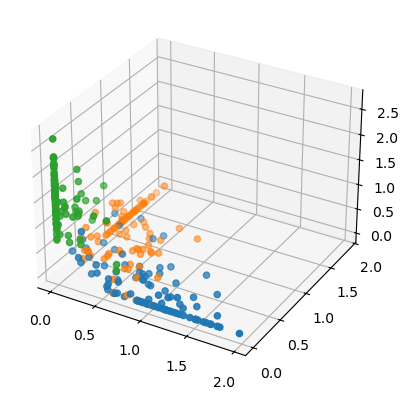

In [222]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(embeddings[:,0], embeddings[:,1], embeddings[:,2], color=y_colors)
plt.show()


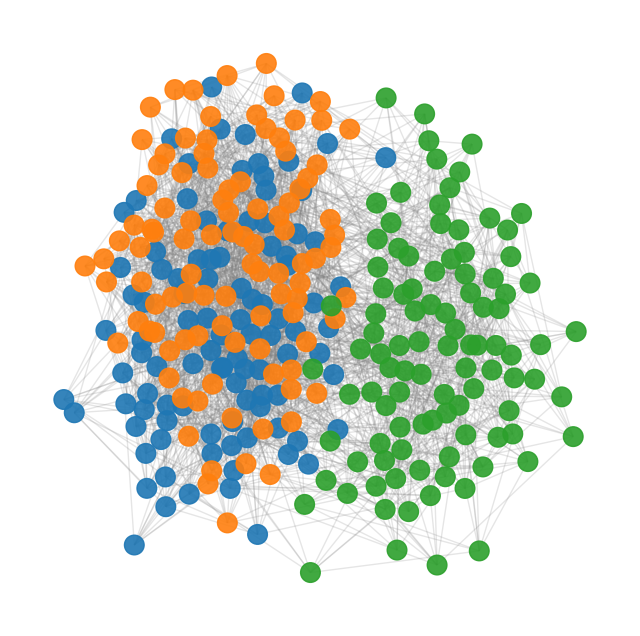

In [223]:
G = to_networkx(dataset[0], to_undirected=True)
node_pos=nx.spring_layout(G, seed=0)
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx_nodes(G,
                pos=node_pos,
                node_size=200,
                node_color=y_colors,
                alpha=0.9
                )
nx.draw_networkx_edges(G,
                pos=node_pos,
                edge_color="grey",
                alpha=0.2
                )
plt.savefig('plot-01.png', bbox_inches='tight', dpi=600)

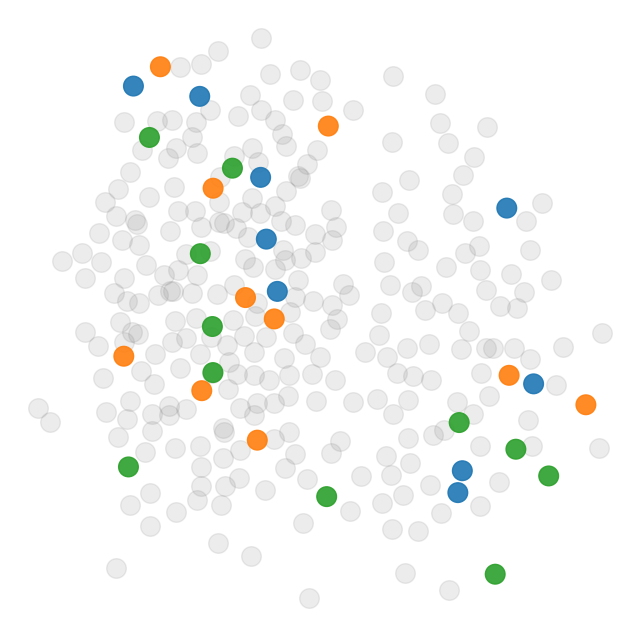

In [224]:
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx_nodes(idx_train_graph,
                pos=node_pos,
                node_size=200,
                node_color='grey',
                alpha=0.15
                )
nx.draw_networkx_nodes(idx_val_graph,
                pos=node_pos,
                node_size=200,
                node_color='grey',
                alpha=0.15
                )
nx.draw_networkx_nodes(idx_test_graph,
                pos=node_pos,
                node_size=200,
                node_color=idx_test_graph_colors_preds,
                alpha=0.9
                )

plt.savefig('plot-02.png', bbox_inches='tight', dpi=600)